# <p style="text-align: center;"> RL-enhanced MBQC </p>


We want to use a RL agent to find a measurement pattern in some cluster/graph state that implements some unknown gate $U$
<img src="./assets/images/interactionDrawing.png" width="500">


Let us import some important libraries

In [1]:
import os
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group
import scipy as scp
import networkx as nx

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

Import the mbqc_env, an environment that allows interaction between RL agent and the quantum mechanical system specified by the MBQC model.  

In [2]:
from env_mbqc import *

## Let's see some examples:

We want to check what types of gates can the agent learn. To start, we consider single-qubit gates and then study two-qubit gates.

### One qubit gates:

We define a resource state that is capable of implementing the unitary gate, in this case, we will use a 1D five-qubits chain.

In [3]:
#define our graph
gr = nx.Graph()
gr.add_nodes_from(list(range(5)))
gr.add_edges_from([(0, 1),(1,2),(2,3),(3,4)])

#pick a one-qubit unitary gate to learn
unitary_random = unitary_group.rvs(2)

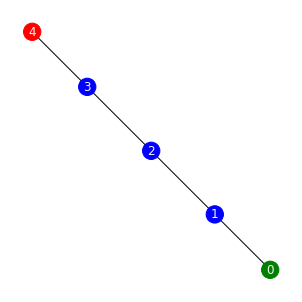

In [4]:
#plots graph state
fig = plt.figure(1, figsize=(4, 4))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node == 0:
        color_map.append('green')
    elif node ==4:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [5]:
#create environment and path for log file
env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)
log_dir = "./logs/logs1"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [6]:
#define and train the model
model = PPO("MlpPolicy", env, verbose=0);
model.learn(total_timesteps=int(1e5), callback=event_callback)

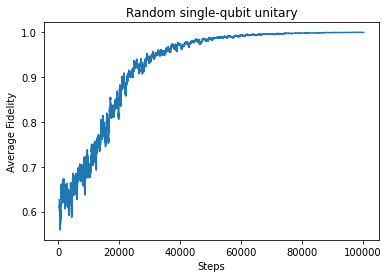

In [7]:
#plot learning curve of the agent
plot_results(log_dir, title="Random single-qubit unitary",w=100)

### Two qubit gates:

General Controlled-U gate:

In [6]:
def controlled_unitary(i, j,u, n):
    """
    controlled_unitary gate with 
    i: control qubit
    j: target qubit
    u: unitary gate
    n: number of qubits
    """
    op1,op2,op3,op4 = np.ones(4)
    for k in range(1,n+1):
        if k==i or k==j:
            op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
        else:
            op1 = np.kron(op1, np.eye(2))        
        if k == i:
            op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
            op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
        elif k==j:
            op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T,u[0,0]*np.array([[1],[0]])+u[1,0]*np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, u[0,1]*np.array([[1],[0]])+u[1,1]*np.array([[0],[1]])))
        else:
            op2 = np.kron(op2, np.eye(2))
            op3 = np.kron(op3, np.eye(2))
            op4 = np.kron(op4, np.eye(2))

    return op1+op2+op3+op4
    
sqrtsx = 0.5*np.array([[1+1j,1-1j],[1-1j,1+1j]])
controlled_unitary(1,2,sqrtsx,2)

array([[1. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
       [0. +0.j , 1. +0.j , 0. +0.j , 0. +0.j ],
       [0. +0.j , 0. +0.j , 0.5+0.5j, 0.5-0.5j],
       [0. +0.j , 0. +0.j , 0.5-0.5j, 0.5+0.5j]])

For the two quibt case, let us begin with a resource state that we know is capable of performing a CNOT gate:

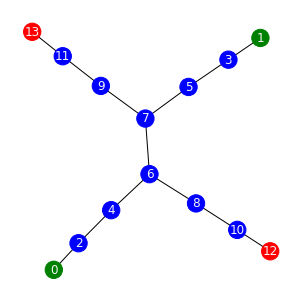

In [7]:
#define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(2,14)))
gr.add_edges_from([(0, 2), (2, 4), (4,6), (6,8),(8,10), (10,12), (6,7), 
                 (1,3),(3,5),(5,7),(7,9),(9,11),(11,13)])

# gr.add_edges_from([(1, 3), (2, 4), (4,6), (6,8),(8,10), (10,13), (6,7), 
#                   (0,2),(3,5),(5,7),(7,9),(9,11),(11,12)])

# gr.add_edges_from([ (2, 4), (4,6), (6,8),(8,10), (10,12), (6,7), 
#                  (3,5),(5,7),(7,9),(9,11),(11,13)])

#plots graph state
fig = plt.figure(1, figsize=(4, 4))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node in [0,1]:
        color_map.append('green')
    elif node in [12,13]:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [9]:
#create environment and path for log file
env2 = mbqc_env(12, 2, gr, lambda x: x+2,  cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)

log_dir2 = "./logs/logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir2)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [10]:
#Define and train the agent
model2 = PPO("MlpPolicy", env2, verbose=0)
model2.learn(total_timesteps=int(2e5), callback=event_callback)

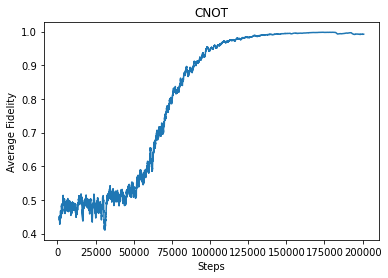

In [11]:
#plot learning curve of CNOT
plot_results(log_dir2, title="CNOT", w=100)

Let us now try some different resoruce, one that is capable of implementing any 2-qubit gate:

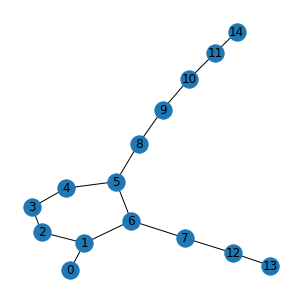

In [12]:
#Define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(15)))
gr.add_edges_from([(0, 1), (1, 2), (2,3), (3,4),(4,5),
                   (6,1), (6,5),(6,7),(7,12),(12,13), (5,8),(8,9),(9,10),(10,11),(11,14)])

#plots graph state
fig = plt.figure(1, figsize=(4, 4))
xpp = nx.spring_layout(gr)
nx.draw(gr,with_labels = True)
plt.axis('off');

In [11]:
#Define flow on graph gr
#Define flow on graph gr
def flow_function(i):
    output = 0
    if i==6:output=10
    elif i in [5,9,10,11]: output=i+2
    else: output = i+1
    return output

#Pick any 2-qubit gate:
unitary_random2 = unitary_group.rvs(4)

In [39]:
env3 = mbqc_env(12, 2, gr, flow_function, cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, input_state_indxs = [6,0,1])

log_dir3 = "./logs/logs3/"
os.makedirs(log_dir3, exist_ok=True)
env3 = Monitor(env3, log_dir3)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir3)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [40]:
#Define and train the agent
model3 = PPO("MlpPolicy", env3, verbose=0)
model3.learn(total_timesteps=int(2e5), callback=event_callback)

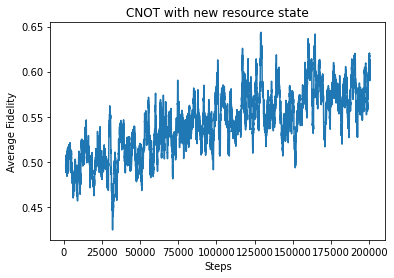

In [41]:
#Plots learning curve obtained by the agent using the new graph state.
#plot_results(log_dir3, title="Random two-qubit unitary", w=100)
plot_results(log_dir3, title="CNOT with new resource state", w=100)

## Performance of agent trained with noisy data:

In [21]:
gr = nx.Graph()
gr.add_nodes_from(list(range(5)))
gr.add_edges_from([(0, 1),(1,2),(2,3),(3,4)])

def get_noisy_data(noise_type, noise_interval):
    """
    Makes a data list of fidelities obtained by the agent when learning Hadamard gate under noise "noise_type" 
    with different noise strength in "noise_interval".
    
    Input:
    noise_type: valid noise type ("random", "bitflip", "none")
    noise_interval: array with different values of noise strength.
    
    Output:
    random_noise_data: List of 100-dim arrays where each entry is the fidelity of a round realized by the trained agent
    
    """
    random_noise_data = []
    for noise_strength in noise_interval:
        env = mbqc_env(4, 1, gr, lambda x: x+1, H, noise=noise_strength, noise_type=noise_type,test_fidelity=False, init_state_random = True)
        log_dir = "./logs/logs1"
        os.makedirs(log_dir, exist_ok=True)
        env = Monitor(env, log_dir)

        checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
        event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=int(5e4), callback=event_callback)

        values = np.array([])
        env = mbqc_env(4, 1, gr, lambda x: x+1, H, noise=noise_strength, noise_type=noise_type,test_fidelity=True, init_state_random = True)
        for i in range(100):
            obs = env.reset()
            done = False
            while not done:
                action, states = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                if done:
                    values = np.append(values, [reward])
        env.close()
        random_noise_data.append(values)
    return random_noise_data

def mean_and_std_data(data):
    """
    Obtains the mean and the std of each 100-dim array obtained as output of the function get_noisy_data(...)
    """
    random_data_mean = []
    random_data_std = []
    for (indx,i) in enumerate(range(len(data))):
        random_data_mean.append(np.mean(data[indx]))
        random_data_std.append(np.std(data[indx]))
    return random_data_mean,random_data_std

#### 1) Random noise in training data

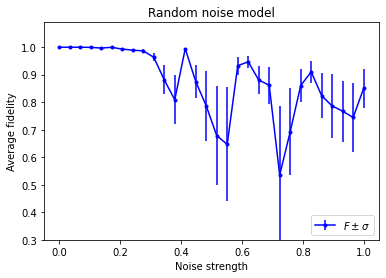

In [22]:
#trains and tests 30 different agents inside random-noise enviroments with different noise strengths values. 
random_noise_data = get_noisy_data("random", np.linspace(0,1,30))
random_data_mean,random_data_std = mean_and_std_data(random_noise_data)

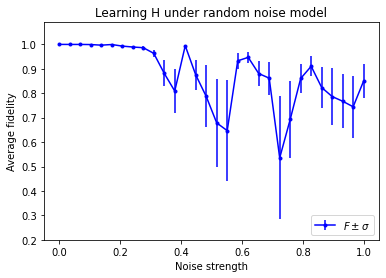

In [26]:
#plots mean and std for each run.
plt.errorbar(np.linspace(0,1,30), random_data_mean, yerr = random_data_std, c='b', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=4)
plt.xlabel("Noise strength")
plt.ylabel("Average fidelity")
plt.ylim(0.2,1.09)
plt.title("Learning H under random noise model")
plt.show()

#### 2) Bitflip error channel on training data

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


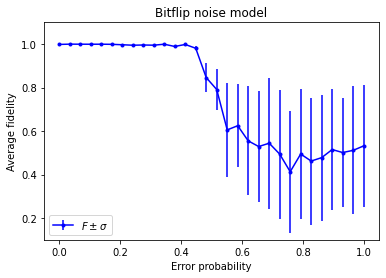

In [23]:
#trains and tests 30 different agents inside bitflip-noise enviroments with different noise strengths values. 
bitflip_noise_data = get_noisy_data("bitflip",np.linspace(0,1,30))
bitflip_data_mean, bitflip_data_std = mean_and_std_data(bitflip_noise_data)

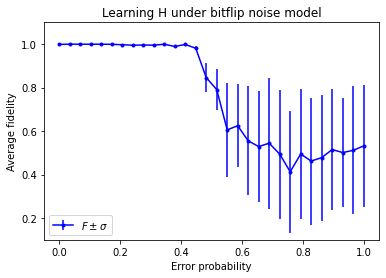

In [24]:
#plots mean and std for each run.
plt.errorbar(np.linspace(0,1,30), bitflip_data_mean, yerr= bitflip_data_std, c='b', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=3)
plt.xlabel("Error probability")
plt.ylabel("Average fidelity")
plt.ylim(0.1,1.1)
plt.title("Learning H under bitflip noise model")
plt.show()

## Finding measurement angles using optimization protocols:

In [16]:
from scipy import optimize

In [17]:
#define our graph
gr = nx.Graph()
gr.add_nodes_from(list(range(5)))
gr.add_edges_from([(0, 1),(1,2),(2,3),(3,4)])

#pick a one-qubit unitary gate to learn
unitary_random = unitary_group.rvs(2)

In [18]:
step_minim = []
val_minim = []
STEP = 0

def fid_fun(angles):
    global STEP
    env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)
    fids = []
    for k in range(15):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids.append(reward)
    env.close()
    output =  np.mean(fids)
    step_minim.append(STEP)
    STEP+=4*15
    val_minim.append(output)
    return -output


In [19]:
optimize.minimize(fid_fun, np.random.rand(4), method='COBYLA')

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


     fun: -1.0000000012622687
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 71
  status: 1
 success: True
       x: array([ 0.70123437,  1.9374497 ,  1.84921338, -0.41992353])

Text(0, 0.5, 'Fidelity')

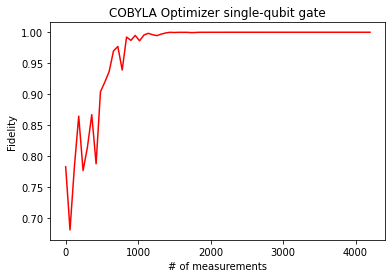

In [20]:
plt.plot(step_minim, val_minim, c='r')
plt.title("COBYLA Optimizer single-qubit gate")
plt.xlabel("# of measurements")
plt.ylabel("Fidelity")

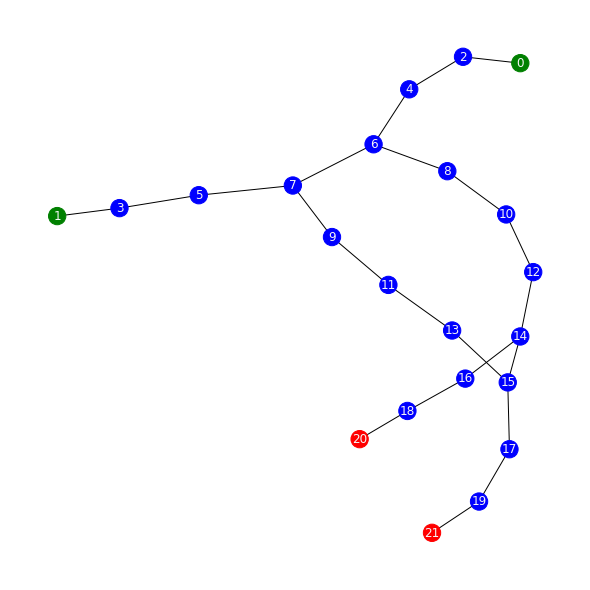

In [21]:
#define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(22)))

gr.add_edges_from([(0, 2), (2, 4), (4,6), (6,8),(8,10), (10,12),(12,14), (6,7), 
                 (1,3),(3,5),(5,7),(7,9),(9,11),(11,13),(13,15), (14,15), (14,16),(15,17),(16,18),(17,19),
                   (18,20),(19,21)])

#plots graph state
fig = plt.figure(1, figsize=(8, 8))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node in [0,1]:
        color_map.append('green')
    elif node in [20,21]:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [22]:
step_minim = []
val_minim = []
STEP = 0

def fid_fun(angles):
    global STEP
    env =mbqc_env(20, 2, gr, lambda x: x+2, controlled_unitary(1,2,sqrtsx,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)
    fids = []
    for k in range(25):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids.append(reward)
    env.close()
    output =  np.mean(fids)
    step_minim.append(STEP)
    STEP+=20*25
    val_minim.append(output)
    return -output

In [23]:
optimize.minimize(fid_fun, np.random.rand(20), method='COBYLA', tol=1e-4)

In [ ]:
plt.plot(step_minim, val_minim, c='r')
plt.title("COBYLA Optimizer CSQRT[X] (20 measurements)")
plt.xlabel("Steps")
plt.ylabel("Fidelity")

### Using COBYLA when there is noise (?)

In [ ]:
step_minim = []
val_minim = []
STEP = 0

def fid_fun(angles,noisee):
    global STEP
    env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=noisee, noise_type="bitflip" ,test_fidelity=False, init_state_random = True)
    fids = []
    for k in range(25):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids.append(reward)
    env.close()
    
    env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=noisee, noise_type="bitflip" ,test_fidelity=True, init_state_random = True)
    fids2 = []
    for k in range(10):
        obs = env.reset()
        done,i = False, 0
        while not done:
            obs, reward, done, info = env.step([angles[i]])
            i+=1
            if done:
                fids2.append(reward)
    env.close()
    
    output =  np.mean(fids)
    step_minim.append(STEP)
    STEP+=1
    val_minim.append(np.mean(fids2))
    return -output

noises = []
val_minims_avg = []
val_minims_std = []

for nois in np.linspace(0,1,30):
    run_vals = []
    for optims in range(30):
        step_minim = []
        val_minim = []
        STEP = 0
        optimize.minimize(lambda angles: fid_fun(angles, nois), np.random.rand(4),method='COBYLA', tol=1e-3)
        run_vals.append(val_minim[-1]) 
    noises.append(nois)
    val_minims_avg.append(np.mean(run_vals))
    val_minims_std.append(np.std(run_vals))

In [ ]:
#FIDELITY TEST TRUE
plt.errorbar(noises,val_minims_avg,yerr=val_minims_std,c='r', marker='.')
plt.xlabel("Noise p")
plt.ylabel("Fidelity")
plt.title("Learning random single-qubit unitary under bitflip noise")